In [79]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy import stats
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# load data
df = pd.read_csv(r"C:\Users\danog\Documents\DS Projects\German Credit Risk\dataset.csv",index_col=0)

In [3]:
# first look at the data
print(df.head())
print(df.info())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-nul

In [4]:
# explore missing values
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [5]:
# look at values in variables with missing values
print(df['Saving accounts'].unique())
print(df['Checking account'].unique())

[nan 'little' 'quite rich' 'rich' 'moderate']
['little' 'moderate' nan 'rich']


In [6]:
# fill missing values
df['Saving accounts'] = df['Saving accounts'].fillna('no_info')
df['Checking account'] = df['Checking account'].fillna('no_info')

In [7]:
# rename columns
df.rename({'Saving accounts':'Savings','Checking account':'Checking','Credit amount':'Credit'}, axis=1, inplace=True)

In [8]:
# replace "Purpose" data with shorter strings
df['Purpose'].replace(['radio/TV',  'furniture/equipment', 'domestic appliances', 'vacation/others'],
                      ['media', 'furniture', 'household', 'others'], inplace=True)

In [9]:
# add job title column
def job_title (row):
    if row['Job'] == 0:
        return 'unskilled nonresident'
    if row['Job'] == 1:
        return 'unskilled resident'
    if row['Job'] == 2:
        return 'skilled'
    if row['Job'] == 3:
        return 'highly skilled'

df['Job'] = df.apply(job_title, axis=1)

In [10]:
# change order of columns
df = df[['Risk', 'Age', 'Credit', 'Duration', 'Sex', 'Job', 'Housing', 'Savings', 'Checking', 'Purpose']].copy()

In [11]:
# create train set for analysis
df_train = df.iloc[:750,:]

### Data exploration

In [12]:
df_train.head()

,Risk,Age,Credit,Duration,Sex,Job,Housing,Savings,Checking,Purpose
0,good,67,1169,6,male,skilled,own,no_info,little,media
1,bad,22,5951,48,female,skilled,own,little,moderate,media
2,good,49,2096,12,male,unskilled resident,own,little,no_info,education
3,good,45,7882,42,male,skilled,free,little,little,furniture
4,bad,53,4870,24,male,skilled,free,little,little,car


In [13]:
df_train.describe()

,Age,Credit,Duration
count,750.000000,750.000000,750.000000
mean,35.229333,3201.690667,20.657333
std,11.264187,2754.958899,12.277441
min,19.000000,250.000000,4.000000
25%,27.000000,1344.500000,12.000000
50%,33.000000,2281.500000,18.000000
75%,41.000000,3940.500000,24.000000
max,75.000000,15945.000000,72.000000


#### Target variable analysis

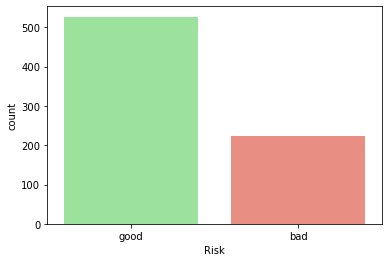

In [14]:
# count good/bad risk
sns.countplot(x = "Risk", data = df_train, palette=['lightgreen','salmon'])
plt.show()

#### Numeric variables analysis

In [15]:
# function for creating charts for numeric data

def num_var_charts(var):
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4), constrained_layout=True)
    fig.suptitle(var + ' analysis', fontsize=16)

    sns.histplot(x=var, data=df_train, color='grey', ax=ax1, bins=20, label='all')
    sns.histplot(x=df_train.loc[df_train['Risk']=='good',var], data=df_train, color='lightgreen', ax=ax1, bins=20, label='good')
    sns.histplot(x=df_train.loc[df_train['Risk']=='bad',var], data=df_train, color='salmon', ax=ax1, bins=20, label='bad')
    ax1.legend(loc=1)
    ax1.set_title('Distribution')    

    sns.kdeplot(x=var, data=df_train, color='grey', ax=ax2, label='all')
    sns.kdeplot(x=df_train.loc[df_train['Risk']=='good',var], data=df_train, color='lightgreen', ax=ax2, label='good')
    sns.kdeplot(x=df_train.loc[df_train['Risk']=='bad',var], data=df_train, color='salmon', ax=ax2, label='bad')
    ax2.legend(loc=1)
    ax2.set_title('KDE plot')
    
    plt.show()

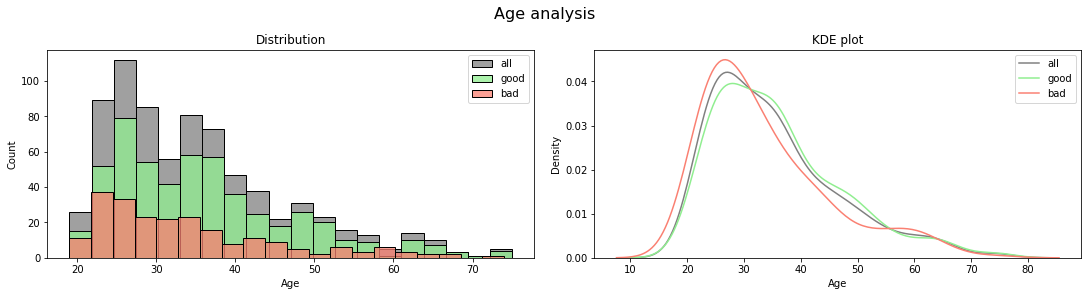

In [16]:
num_var_charts('Age')

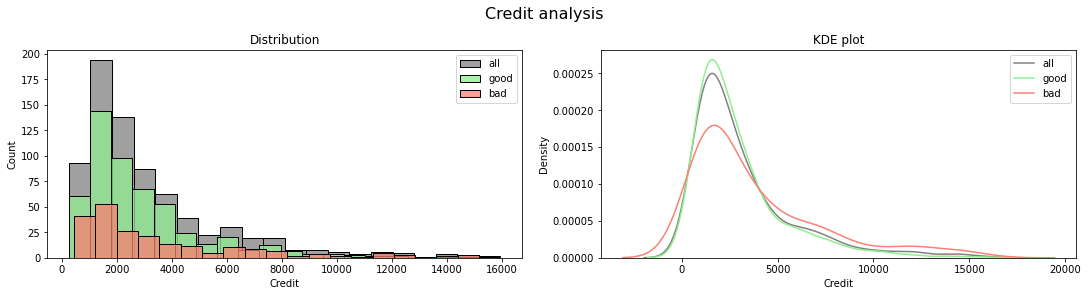

In [17]:
num_var_charts('Credit')

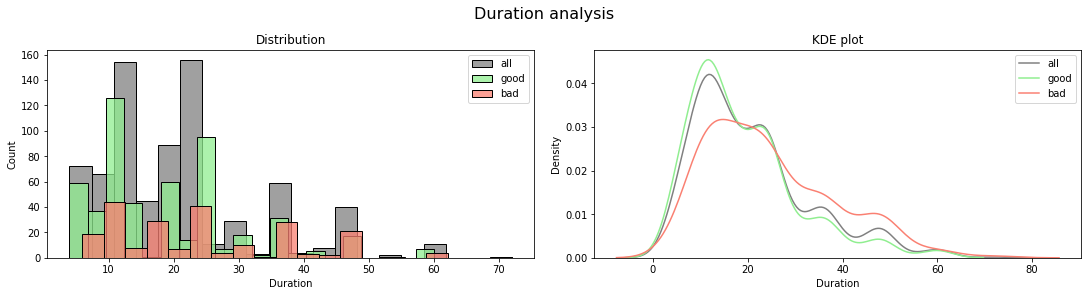

In [18]:
num_var_charts('Duration')

#### Categorical variables analysis

In [19]:
# function for getting stats for categorical data
def cat_var_stats(var):
    count = df_train[var].value_counts()
    count_bad = df_train[df_train['Risk']=='bad'][var].value_counts()
    count_good = df_train[df_train['Risk']=='good'][var].value_counts()
    df_var = (pd.concat([count.rename('count'), (count_bad/count).rename('bad %'), (count_good/count).rename('good %')], axis=1))
    df_var = df_var.reset_index().rename(columns={'index': var})
    return df_var

In [20]:
# Function for creating charts for categorical variables
def cat_var_charts(var):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,3), constrained_layout=True)
    fig.suptitle(var + ' analysis', fontsize=16)
    
    sns.countplot(x=var, hue='Risk', data = df_train, palette=['lightgreen','salmon'], ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30) 
    ax1.set_title("Countplot")
    ax1.legend(loc=1)
    ax1.set(xlabel=None)
    
    cat_var_stats(var).plot.bar(x=var, y=['good %','bad %'], color=['lightgreen','salmon'], stacked=True, ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)    
    ax2.set_title('Good/bad ratio')   
    ax2.legend(loc=1)
    ax2.set(xlabel=None)

    sns.boxplot(x=var, y='Credit', hue='Risk', palette=['lightgreen','salmon'], data=df_train, ax=ax3)
    ax3.set_title('Boxplot')   
    ax3.legend(loc=1)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30)
    ax3.set(xlabel=None)

    plt.show()

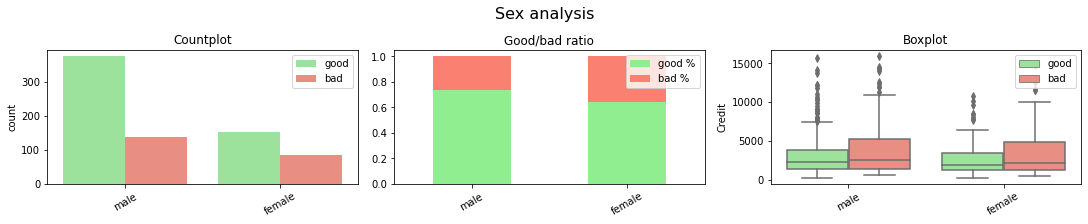

In [21]:
cat_var_charts('Sex')

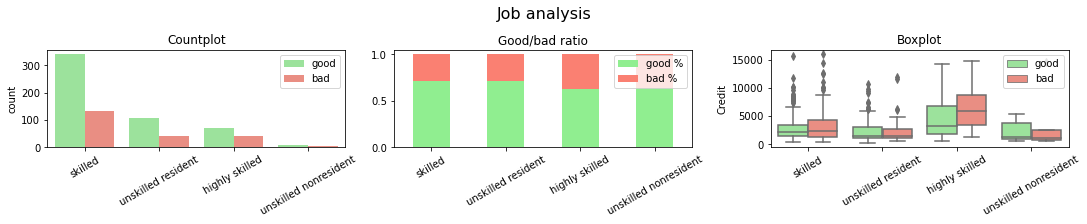

In [22]:
cat_var_charts('Job')

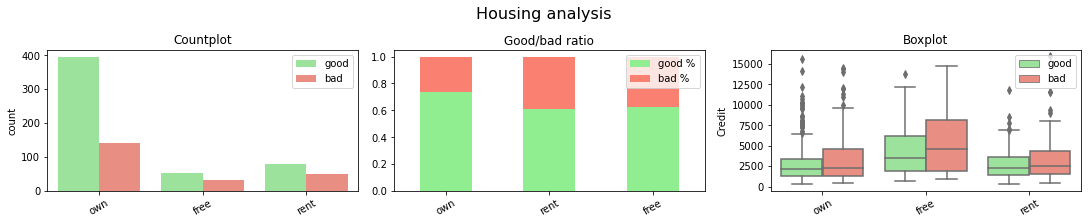

In [23]:
cat_var_charts('Housing')

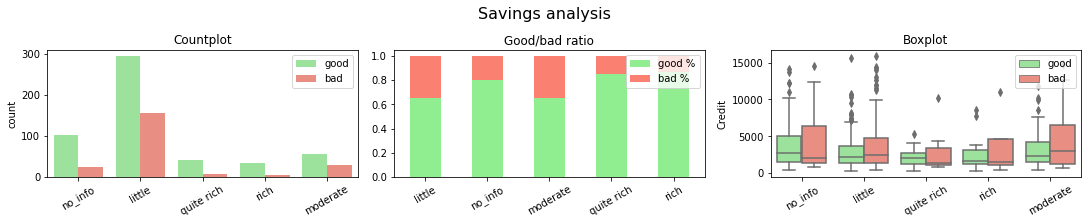

In [24]:
cat_var_charts('Savings')

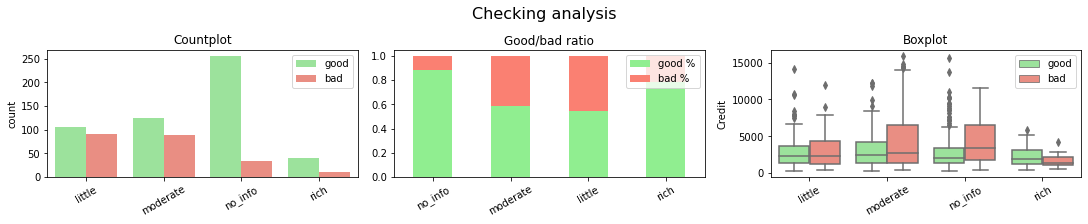

In [25]:
cat_var_charts('Checking')

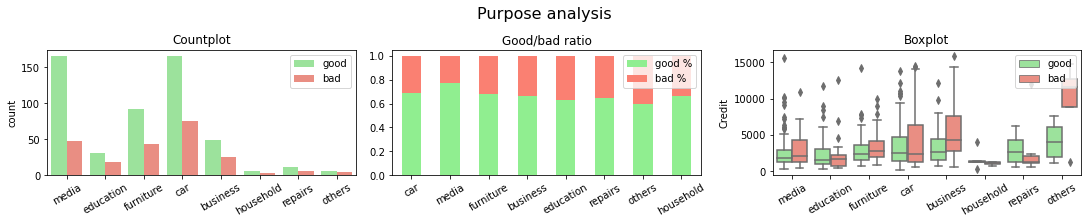

In [26]:
cat_var_charts('Purpose')

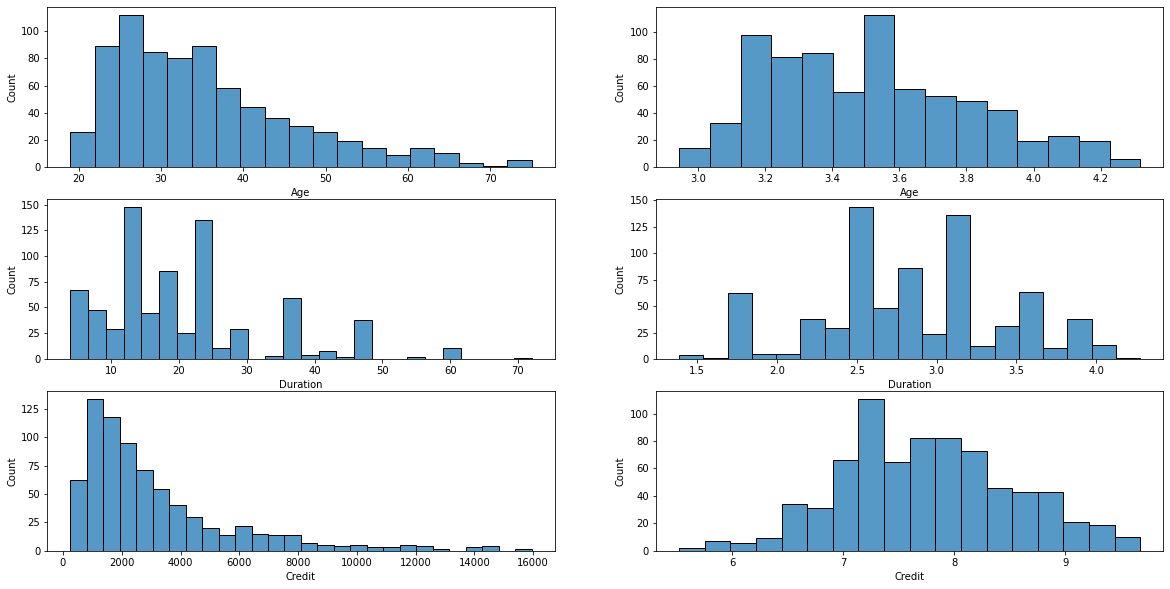

In [27]:
# Exploring skeweness and log-transformations
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
sns.histplot(x=df_train.Age, data=df_train, ax=ax1)
sns.histplot(x=np.log(df_train.Age), data=df_train, ax=ax2)
sns.histplot(x=df_train.Duration, data=df_train, ax=ax3)
sns.histplot(x=np.log(df_train.Duration), data=df_train, ax=ax4)
sns.histplot(x=df_train.Credit, data=df_train, ax=ax5)
sns.histplot(x=np.log(df_train.Credit), data=df_train, ax=ax6)
plt.show()

In [28]:
# create dummy variables
df = df.merge(pd.get_dummies(df.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df.Job, drop_first=True, prefix='Job'), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df.Savings, drop_first=True, prefix='Savings'), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df.Checking, drop_first=True, prefix='Checking'), left_index=True, right_index=True)
df = df.merge(pd.get_dummies(df.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)

In [29]:
df.columns

Index(['Risk', 'Age', 'Credit', 'Duration', 'Sex', 'Job', 'Housing', 'Savings',
       'Checking', 'Purpose', 'Sex_male', 'Job_skilled',
       'Job_unskilled nonresident', 'Job_unskilled resident', 'Housing_own',
       'Housing_rent', 'Savings_moderate', 'Savings_no_info',
       'Savings_quite rich', 'Savings_rich', 'Checking_moderate',
       'Checking_no_info', 'Checking_rich', 'Purpose_car', 'Purpose_education',
       'Purpose_furniture', 'Purpose_household', 'Purpose_media',
       'Purpose_others', 'Purpose_repairs'],
      dtype='object')

In [30]:
# drop columns
df.drop(columns=['Sex', 'Job', 'Housing', 'Savings', 'Checking', 'Purpose'], inplace=True)

In [31]:
# log transformation of skewed variables
df.Age = np.log(df.Age)
df.Duration = np.log(df.Duration)
df.Credit = np.log(df.Credit)

In [32]:
# convert target variable to binary data: 0=good, 1=bad
df['Risk'].replace(['good', 'bad'], [0,1], inplace=True)

In [58]:
# Spliting df into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=False)
X_train = df.iloc[:750,1:]
y_train = df.iloc[:750,0]
X_test = df.iloc[750:,1:]
y_test = df.iloc[750:,0]

In [59]:
# apply min-max scaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

#### Logistic regression

In [60]:
# model, kfold, scores
model = LogisticRegression()
kfold = KFold(n_splits=10, shuffle=False)
scores = ['accuracy','f1','precision','recall','roc_auc']

In [67]:
# first model
table_logreg = pd.DataFrame(index=np.arange(10)) 

for i in scores:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=i)
    output = pd.DataFrame(cv_results, columns=[i])
    table_logreg = pd.merge(table_logreg, output, left_index=True, right_index=True)
    
table_logreg.mean()
table_logreg.std()

accuracy     0.070118
f1           0.127818
precision    0.153837
recall       0.134743
roc_auc      0.075704
dtype: float64

In [68]:
# model with smote
table_logreg_smt = pd.DataFrame(index=np.arange(10)) 

for i in scores:
    imba_pipeline = make_pipeline(SMOTE(random_state=42), model)
    cv_results = cross_val_score(imba_pipeline, X_train, y_train, cv=kfold, scoring=i)
    output = pd.DataFrame(cv_results, columns=[i])
    table_logreg_smt = pd.merge(table_logreg_smt, output, left_index=True, right_index=True)
    
table_logreg_smt.mean()
table_logreg_smt.std()

accuracy     0.049968
f1           0.079405
precision    0.067375
recall       0.131493
roc_auc      0.084318
dtype: float64

In [69]:
# model with feature elimination / selection

rfe = RFE(model)
rfe = rfe.fit(X_train, y_train)
rfe_columns = X_train.columns[rfe.support_]

table_logreg_smt_rfe = pd.DataFrame(index=np.arange(10)) 

for i in scores:
    imba_pipeline = make_pipeline(SMOTE(random_state=42), model)
    cv_results = cross_val_score(imba_pipeline, X_train[X_train.columns[rfe.support_]], y_train, cv=kfold, scoring=i)
    output = pd.DataFrame(cv_results, columns=[i])
    table_logreg_smt_rfe = pd.merge(table_logreg_smt_rfe, output, left_index=True, right_index=True)
    
table_logreg_smt_rfe.mean()
table_logreg_smt_rfe.std()

accuracy     0.041716
f1           0.074714
precision    0.068199
recall       0.123888
roc_auc      0.069915
dtype: float64

In [108]:
os = SMOTE(random_state=42)
X_train_os, y_train_os = os.fit_sample(X_train, y_train)
model.fit(X_train_os, y_train_os)
y_pred = model.predict(X_test)

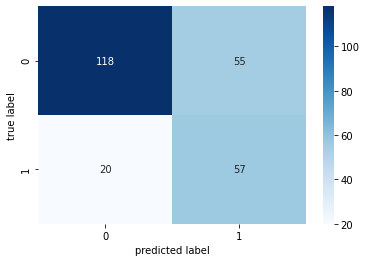

In [110]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       173
           1       0.51      0.74      0.60        77

    accuracy                           0.70       250
   macro avg       0.68      0.71      0.68       250
weighted avg       0.75      0.70      0.71       250

